# Ingest Simulated Data

Read the simulated images from a zip file, extract labels from filename, split into stratified train/test sets and write out to tfrecord files on the PRP CEPH/S3 cluster with public access so they can be used from Colab

In [1]:
import os
import io
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
# Switch to scratch data directory on local machine
!mkdir -p ~/data/braingeneers/simulated
os.chdir(os.path.expanduser("~/data/braingeneers/simulated"))

Found 49 unique labels


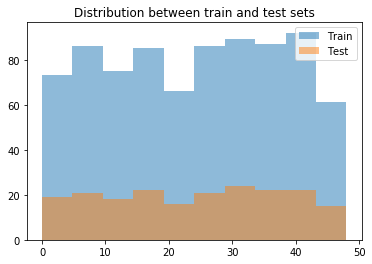

In [3]:
# Extract labels from filenames and split with associated path into stratified train/test
with zipfile.ZipFile("mltest-cropped.zip", "r") as f:
    paths = [path for path in filter(lambda p: p.endswith(".png"), f.namelist())]
    labels = [int(re.findall(r".*?\/\w+_(\d+)", path)[0]) for path in paths]
print("Found {} unique labels".format(len(set(labels))))
        
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.20)

# Plot labels in train/test to verify stratification
plt.hist(y_train, alpha=0.5, label='Train')
plt.hist(y_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Distribution between train and test sets")
plt.show()

In [4]:
def write_dataset(src, dest, paths, labels):
    """
    For each path and label extract a blob from src zip file and write to dest tfrecord file
    """
    with zipfile.ZipFile(src, "r") as archive:
        with tf.python_io.TFRecordWriter(dest) as writer:
            for path, label in zip(paths, labels):
                writer.write(tf.train.Example(features=tf.train.Features(feature = {
                    "example": tf.train.Feature(bytes_list=tf.train.BytesList(value=[archive.read(path)])),
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)]))
                })).SerializeToString())

write_dataset("mltest-cropped.zip", "mltest-cropped-train.tfrecord", X_train, y_train)
write_dataset("mltest-cropped.zip", "mltest-cropped-test.tfrecord", X_test, y_test)

print("Wrote {} training and {} test examples".format(len(X_train), len(X_test)))

Wrote 800 training and 200 test examples


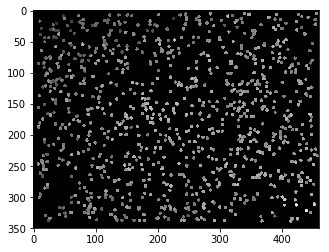

In [5]:
# Open up an example, display and extract some meta data we'll need for training
import PIL
with zipfile.ZipFile("mltest-cropped.zip", "r") as archive:
    image = PIL.Image.open(io.BytesIO(archive.read(X_train[0])))
    plt.imshow(image)

import json
with open("metadata.json", "w") as f:
    f.write(json.dumps({
        "dataset": "simulated",
        "description": "https://github.com/braingeneers/braingeneers/issues/3",
        "labels": sorted(list(set(y_test))),
        "train_examples_name": "mltest-cropped-train.tfrecord",
        "test_examples_name": "mltest-cropped-test.tfrecord",
        "num_train_examples": len(X_train),
        "num_test_examples": len(X_test),
        "image_width": image.size[0],
        "image_height": image.size[1]
    }))

# Upload to S3

These files are now accessible publicly external to the PRP under 

https://s3.nautilus.optiputer.net/braingeneers/simulated/
    
and internal to the PRP at the endpoint:

s3://rook-ceph-rgw-rooks3.rook

In [6]:
# Empty the path
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 rm --recursive s3://braingeneers/simulated

delete: s3://braingeneers/simulated/mltest-cropped.zip
delete: s3://braingeneers/simulated/metadata.json
delete: s3://braingeneers/simulated/mltest-cropped-train.tfrecord
delete: s3://braingeneers/simulated/mltest-cropped-test.tfrecord


In [7]:
# Use the aws cli's rsync like sync command to push changed files up to PRP S3/CEPH
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 sync . s3://braingeneers/simulated --acl public-read

upload: ./metadata.json to s3://braingeneers/simulated/metadata.json
upload: ./mltest-cropped-test.tfrecord to s3://braingeneers/simulated/mltest-cropped-test.tfrecord
upload: ./mltest-cropped-train.tfrecord to s3://braingeneers/simulated/mltest-cropped-train.tfrecord
upload: ./mltest-cropped.zip to s3://braingeneers/simulated/mltest-cropped.zip


In [8]:
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 ls s3://braingeneers/simulated/

2018-11-07 23:30:29        498 metadata.json
2018-11-07 23:30:29    6357605 mltest-cropped-test.tfrecord
2018-11-07 23:30:30   25113147 mltest-cropped-train.tfrecord
2018-11-07 23:30:30   31577599 mltest-cropped.zip


## Reload and Display

Load the dataset directly from S3 and verify we can visualize and image

In [9]:
import requests

metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/simulated/metadata.json").json()
metadata.keys()

dict_keys(['num_test_examples', 'dataset', 'num_train_examples', 'labels', 'train_examples_name', 'image_height', 'description', 'test_examples_name', 'image_width'])

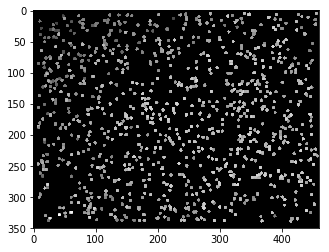

In [10]:
def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    return example["example"], tf.one_hot(example["label"], len(metadata["labels"]))

training_dataset = tf.data.TFRecordDataset(["s3://braingeneers/simulated/mltest-cropped-test.tfrecord"])

# Extract and display first image
# https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding
example, label = parse_one_example(training_dataset.make_one_shot_iterator().get_next())
image = tf.image.decode_image(example)

assert metadata["image_width"] == image.shape[1].value
assert metadata["image_height"] == image.shape[0].value

plt.imshow(image.numpy().reshape(image.shape[0], image.shape[1]), cmap='gray')